# belief eye neural analysis


### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [3]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA

In [4]:
# misc
import pickle
from collections import defaultdict

In [5]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

# load data

In [6]:
df = pd.read_pickle(resdir/'0617_m51df.pkl')
len(df)
df=df[df.session==41]

In [7]:
def process_one(y):
    related_taskvar=np.array(normalize_z(y))
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    related_taskvar[~mask]=0
    return related_taskvar, mask

def process(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=np.all(mask, axis=1)
    related_taskvar=related_taskvar[mask]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar
def process_list(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    mask=[(a > -4) & (a < 4) for a in rawtaskvar]
    mask=np.all(mask)
    related_taskvar=[a[mask] for a in rawtaskvar]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar

In [8]:
# error distribution
def get_stop_error(row):
    return ((row.fx[-1]-row.mx[-1])**2+(row.fy[-1]-row.my[-1])**2)**0.5
df['state_error']=df.apply(get_stop_error, axis=1)
def get_stop_error(row):
    return ((row.fx[-1]-row.bmx[-1])**2+(row.fy[-1]-row.bmy[-1])**2)**0.5
df['belief_error']=df.apply(get_stop_error, axis=1)

# time ratio
df['time_ratio']=df.apply(lambda x: x.timer/x.timer[-1], axis=1)


In [9]:
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
belief=np.concatenate(sessdf.ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timeratio=np.concatenate(sessdf.time_ratio.to_numpy())
timer=np.concatenate(sessdf.timer.to_numpy())
countdown=np.concatenate(sessdf.countdown.to_numpy())


In [12]:
# make a df by time (each row is a time, instead of a trial)
sessdf['density_t']=sessdf.apply(lambda x: np.array([[x.density]*len(x.mx)]).reshape(-1), axis=1)
sessdf['fullon_t']=sessdf.apply(lambda x: np.array([[x.fullon]*len(x.mx)]).reshape(-1), axis=1)
sessdf['error_t']=sessdf.apply(lambda x: np.array([[x.error]*len(x.mx)]).reshape(-1), axis=1)



timedf=pd.DataFrame({'timer':timer})
timedf['cov']=list(np.vstack(sessdf['cov'].to_numpy()))
timedf['belief']=np.concatenate(sessdf.belief_ff_hori.to_numpy())
timedf['state']=np.concatenate(sessdf.ff_hori.to_numpy())
timedf['eye']=np.concatenate(sessdf.eye_hori.to_numpy())
timedf['timeratio']=np.concatenate(sessdf.time_ratio.to_numpy())
timedf['mv']=np.concatenate(sessdf.mv.to_numpy())
timedf['mw']=np.concatenate(sessdf.mw.to_numpy())
timedf['belief_heading']=np.concatenate(sessdf.belief_heading.to_numpy())
timedf['timer']=np.concatenate(sessdf.timer.to_numpy())
timedf['countdown']=np.concatenate(sessdf.countdown.to_numpy())
timedf['belief_angle_from_start']=np.concatenate(sessdf.belief_angle_from_start.to_numpy())
timedf['PPC']=list(np.vstack(sessdf.PPC.to_numpy()))

timedf['density']=np.concatenate(sessdf.density_t.to_numpy())
timedf['fullon']=np.concatenate(sessdf.fullon_t.to_numpy())
timedf['error']=np.concatenate(sessdf.error_t.to_numpy())


timedf['dbelief']=np.concatenate(sessdf.apply(lambda x: np.diff(x.belief_ff_hori, prepend=x.belief_ff_hori[:1],axis=0),axis=1).to_numpy())
timedf['deye']=np.concatenate(sessdf.apply(lambda x: np.diff(x.eye_hori, prepend=x.eye_hori[:1],axis=0),axis=1).to_numpy())
timedf['dneural']=list(np.vstack(sessdf.apply(lambda x: np.diff(x.PPC, prepend=x.PPC[:1], axis=0),axis=1).to_numpy()))

timedf.head()
timedf = timedf.dropna(subset=['eye', 'state', 'belief'])

Text(0, 0.5, 'obs')

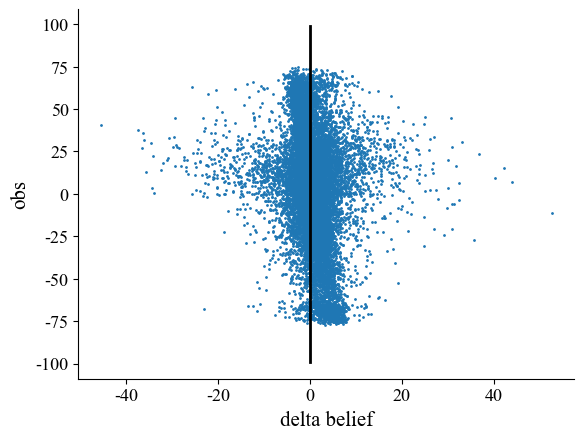

In [13]:
thisx,thisy=timedf.dbelief, timedf.mw
plt.scatter(thisx,thisy, s=1)
plt.plot([0,0],[-99,99], 'k')
plt.xlabel('delta belief')
plt.ylabel('obs')

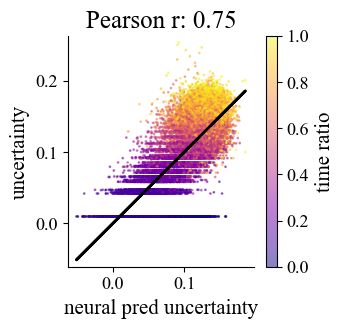

In [15]:
'''# neural to uncertainty (hori direction. **0.5 to same unit)'''

thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf['cov'].to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(thisx,thisy)
thispred=model.predict(thisx)

fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thispred,thisy, c=thisc, cmap='plasma', s=1, alpha=0.5)
plt.colorbar(c, label=f'{thiscname}')

slope=plot_best_fit(thispred,thisy, ax)
r,_=pearsonr(thispred,thisy)
ax.set_title(f'Pearson r: {r:.2f}')

ax.set_xlabel(f'{thisxname}')
ax.set_ylabel(f'{thisyname}')
ax.axis('equal')
plt.show()


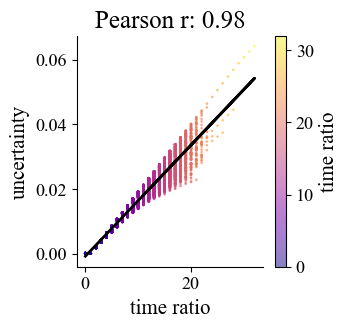

In [16]:
'''# uncertainty tightly correlate with time'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf['cov'].to_numpy())[:,0,0],timedf.timer.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(thisx,thisy)
thispred=model.predict(thisx)
fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thisc,thisy, c=thisc, cmap='plasma', s=1, alpha=0.5)
plt.colorbar(c, label=f'{thiscname}')
slope=plot_best_fit(thisc,thisy, ax)
r,_=pearsonr(thisc,thisy)
ax.set_title(f'Pearson r: {r:.2f}')

ax.set_xlabel(f'{thiscname}')
ax.set_ylabel(f'{thisyname}')
# ax.axis('equal')
plt.show()

In [20]:
timedf.columns                                                           

Index(['timer', 'uncertainty', 'belief', 'state', 'eye', 'timeratio', 'mv',
       'mw', 'belief_heading', 'countdown', 'belief_angle_from_start', 'PPC',
       'density', 'fullon', 'dbelief', 'deye', 'dneural'],
      dtype='object')

In [17]:
# neural to uncertainty (hori direction. **0.5 to same unit)
'''# select uncertainty-time differs (large error)
and check do they have some other task variable dim pattern. have not found yet.
'''

thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0]**0.5,timedf.timer.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(thisx,thisy)
thispred=model.predict(thisx)
err=np.array(normalize_z((thisy-thispred)**2))
mask=err>0.3
thispred,thisy, thisc=thispred[mask],thisy[mask], thisc[mask]
fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thispred,thisy, c=thisc, cmap='plasma', s=1, alpha=0.5)
plt.colorbar(c, label=f'{thiscname}')

slope=plot_best_fit(thispred,thisy, ax)
r,_=pearsonr(thispred,thisy)
ax.set_title(f'Pearson r: {r:.2f}')

ax.set_xlabel(f'{thisxname}')
ax.set_ylabel(f'{thisyname}')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thisc,thisy, c=thisc, cmap='plasma', s=1, alpha=0.5)
plt.colorbar(c, label=f'{thiscname}')
slope=plot_best_fit(thisc,thisy, ax)
r,_=pearsonr(thisc,thisy)
ax.set_title(f'Pearson r: {r:.2f}')

ax.set_xlabel(f'{thiscname}')
ax.set_ylabel(f'{thisyname}')
# ax.axis('equal')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'uncertainty'

AttributeError: 'DataFrame' object has no attribute 'uncertainty'

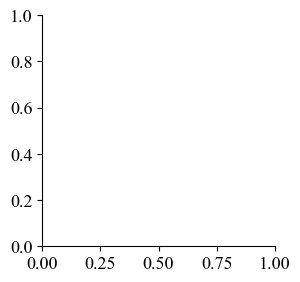

In [22]:
# neural to uncertainty (hori direction. **0.5 to same unit)
'''# select different density
different density should show different uncerainty incresase speed. but minor here. 
could make sense because the animal have very similar performance in different density.
'''
# from matplotlib.colors import ListedColormap
tab10=plt.get_cmap('tab10').colors

fig, ax = plt.subplots(figsize=(3,3))
for thisidx, density in enumerate(sorted(timedf.density.unique())):
    thistimedf=timedf[timedf.density==density]
    thisx,thisy,thisc=np.stack(thistimedf.timeratio.to_numpy()),np.stack(thistimedf.uncertainty.to_numpy())[:,0,0],thistimedf.timer.to_numpy()
    # thisy,thisc=zip(*process_list([thisy,thisc]))
    thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
    # thisc,_=process_one(thisc)
    thisxname, thisyname, thiscname='time', 'uncertainty','time ratio'

    # from sklearn.linear_model import LinearRegression
    # model = LinearRegression()
    # model.fit(thisx,thisy)
    # thispred=model.predict(thisx)

    c=ax.scatter(thisx,thisy, s=1, alpha=0.1, label=f'{density}')
    # plt.colorbar(c, label=f'{thiscname}')

    slope=plot_best_fit(thisx,thisy, ax, color=tab10[thisidx])
    print(density, slope)
    r,_=pearsonr(thisx,thisy)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'{thisxname}')
    ax.set_ylabel(f'{thisyname}')
    # ax.axis('equal')
# plt.legend()
plt.show()


In [23]:
'''# follow up, neural could encode just time. use cca to show neural encode both time and uncertainty
use cca to seperate time and unceratinty. not good
'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
cca = CCA(n_components=2)
cca_neural, cca_be=cca.fit_transform(thisx,related_taskvar )


varname=['uncertainty', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(cca_neural[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * cca_neural[:,i] + intercept
        ax.plot(cca_neural[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(cca_neural[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'CCA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'uncertainty'

In [24]:
'''# use ica to seperate the time and uncerainty
seperate is not good
'''
thisx,thisy,thisc=np.stack(timedf.PPC.to_numpy()),np.stack(timedf.uncertainty.to_numpy())[:,0,0]**0.5,timedf.timeratio.to_numpy()
# thisy,thisc=zip(*process_list([thisy,thisc]))
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
# thisc,_=process_one(thisc)
thisxname, thisyname, thiscname='neural pred uncertainty', 'uncertainty','time ratio'

related_taskvar=np.stack([thisy, thisc]).T
ica = FastICA(n_components=2)
icaX=related_taskvar
icaS = ica.fit_transform(icaX) 


varname=['uncertainty', 'time']
fig, axs = plt.subplots(2,2, figsize=(5,6))
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        # best fit line
        slope, intercept = np.polyfit(icaS[:,i],related_taskvar[:,j], 1)
        best_fit_line = slope * icaS[:,i] + intercept
        ax.plot(icaS[:,i], best_fit_line, color='black')
        # quickallspine(ax)
        # ax.axis('equal')
        r,_=pearsonr(icaS[:,i],related_taskvar[:,j])
        # ax.set_title(f'x: cca {i+1} \ny: {varname[j]}\nPeason r: {r:.2f}')
        ax.set_title(f'Pearson r: {r:.2f}')
        ax.set_xlabel(f'ICA {i+1}')
        ax.set_ylabel(f'{varname[j]}')
plt.suptitle(f'{session}, PPC', fontsize=22)
plt.tight_layout()
plt.show()


AttributeError: 'DataFrame' object has no attribute 'uncertainty'

# work

In [25]:
# when belief eye are different
'''seems the eye fixes and belief moves at begining of trial (from time ratio plots)
why? could be animal is not rational (did not pay attention) and irc still trys to explain. (irc assumes animla always see the target at begining)
or could be animal eye fix, moves and still thinking/update the belief.
evidence: mk moves. but eye does not.
    if pay attention, mk eye shoudl activly searching


if mk not paying attention. mk dos not see the target. those trials will have larger error and miss rate.
if mk is thinking, trials should have simlar error rate. mk see the target.
'''


'seems the eye fixes and belief moves at begining of trial (from time ratio plots)\nwhy? could be animal is not rational (did not pay attention) and irc still trys to explain. (irc assumes animla always see the target at begining)\nor could be animal eye fix, moves and still thinking/update the belief.\nevidence: mk moves. but eye does not.\n    if pay attention, mk eye shoudl activly searching\n\n\nif mk not paying attention. mk dos not see the target. those trials will have larger error and miss rate.\nif mk is thinking, trials should have simlar error rate. mk see the target.\n'

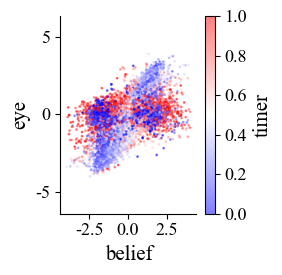

In [25]:
'''
time ratio shows, the x is early on in trials. either strong correlation or no corr. later, corerlation become weak.
'''
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    timer=np.concatenate(sessdf.time_ratio.to_numpy())
    
    related_taskvar, mask = process([state, belief, eye], returnmask=True)
    [state, belief, eye]=zip(*related_taskvar)
    timer=timer[mask]
    # maskvar=np.array(eye)
    # mask=(maskvar<=-2)|(maskvar>2)
    # print(len(eye))
    # state, belief, eye=[np.array(a)[mask] for a in [state, belief, eye]]
    # print(eye.shape)


    fig, ax = plt.subplots(figsize=(3,3))
    c=ax.scatter(belief,eye, c=timer, cmap='bwr', s=1, alpha=0.5)
    plt.colorbar(c, label='timer')

    # slope=plot_best_fit(belief,eye, ax)
    # print(slope)
    # r,_=pearsonr(belief,eye)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')

    plt.tight_layout()

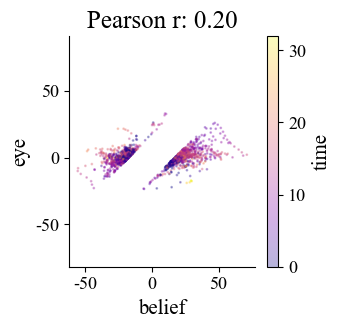

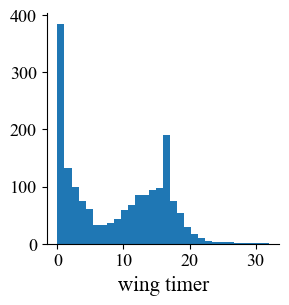

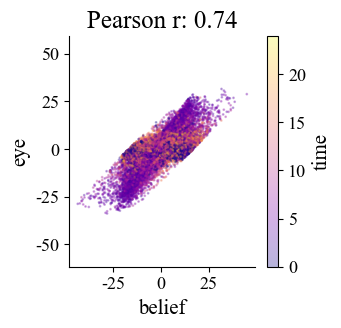

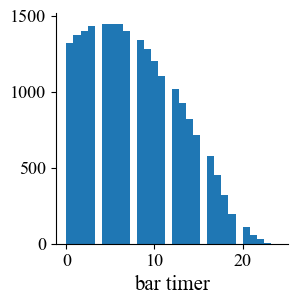

In [26]:
# when belief eye are different (try to seperate the x)
'''idea, there is a x when plot belief-eye scatter. 
can seperate the x by fitting the main bar (smaller err)
small wing has larger error
'''

aa,bb,cc=np.stack(timedf.belief.to_numpy()),np.stack(timedf.eye.to_numpy()),timedf.timer.to_numpy()
thisx,thisy,thisc=aa,bb,cc
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
thisxname, thisyname, thiscname='belief', 'eye', 'time'

# mask the wing by eye and fit.
mask=(thisy<=-11)|(thisy>11)
# mask=(thisy>-11)&(thisy<11)
thisx,thisy,thisc=[a[mask] for a in [thisx,thisy,thisc]]
model = LinearRegression()
model.fit(thisx.reshape(-1,1),thisy.reshape(-1,1))

# fitting ---------------
# fig, ax = plt.subplots(figsize=(3,3))
# ax.scatter(thisx, thisy,c=thisc, s=1, alpha=0.3)
# slope=plot_best_fit(thisx, thisy, ax)
# # print(slope)
# r,_=pearsonr(thisx, thisy)
# ax.set_xlabel(f'belief')
# ax.set_ylabel(f'eye')
# ax.axis('equal')
# ax.set_title(f'Pearson r: {r:.2f}')


# bar 1 -----------------
thisx,thisy,thisc=aa,bb,cc
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
thispred=model.predict(thisx.reshape(-1,1)).reshape(-1)
err=np.array(normalize_z((thisy-thispred)**2))
mask=err>1
thispred,thisy, thisc=thispred[mask],thisy[mask], thisc[mask]

fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thispred,thisy, c=thisc, cmap='plasma', s=1, alpha=0.3)
plt.colorbar(c, label=f'{thiscname}')
# slope=plot_best_fit(thispred,thisy, ax)
r,_=pearsonr(thispred,thisy)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thisxname}')
ax.set_ylabel(f'{thisyname}')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
plt.hist(thisc, bins=30)
plt.xlabel('wing timer')
plt.show()

# bar 2 -----------------
thisx,thisy,thisc=aa,bb,cc
thisx,thisy,thisc=np.array(thisx),np.array(thisy),np.array(thisc)
thispred=model.predict(thisx.reshape(-1,1)).reshape(-1)
err=np.array(normalize_z((thisy-thispred)**2))
mask=err<1
thispred,thisy, thisc=thispred[mask],thisy[mask], thisc[mask]

fig, ax = plt.subplots(figsize=(3,3))
c=ax.scatter(thispred,thisy, c=thisc, cmap='plasma', s=1, alpha=0.3)
plt.colorbar(c, label=f'{thiscname}')
# slope=plot_best_fit(thispred,thisy, ax)
r,_=pearsonr(thispred,thisy)
ax.set_title(f'Pearson r: {r:.2f}')
ax.set_xlabel(f'{thisxname}')
ax.set_ylabel(f'{thisyname}')
ax.axis('equal')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
plt.hist(thisc, bins=30)
plt.xlabel('bar timer')
plt.show()



23140
(1866,)


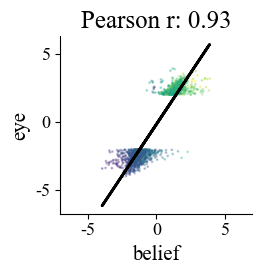

In [27]:


for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    related_taskvar = process([state, belief, eye])
    [state, belief, eye]=zip(*related_taskvar)
    
    maskvar=np.array(eye)
    mask=(maskvar<=-2)|(maskvar>2)
    print(len(eye))
    state, belief, eye=[np.array(a)[mask] for a in [state, belief, eye]]
    print(eye.shape)
    # related_taskvar = process([state, belief, eye])


    thisx, thisy, thisc=belief,eye,state
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(thisx, thisy,c=thisc, s=1, alpha=0.3)

    slope=plot_best_fit(thisx, thisy, ax)
    # print(slope)
    r,_=pearsonr(thisx, thisy)

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')
    ax.set_title(f'Pearson r: {r:.2f}')

    plt.tight_layout()

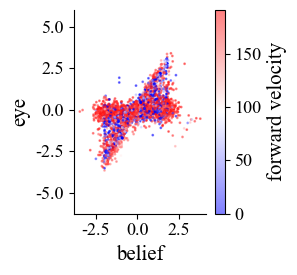

In [28]:
'''
actions at when belief eye differ
no pattern.
'''
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    timer=np.concatenate(sessdf.time_ratio.to_numpy())
    mv=np.concatenate(sessdf.mv.to_numpy())
    mw=np.concatenate(sessdf.mw.to_numpy())
    
    related_taskvar, mask = process([state, belief, eye], returnmask=True)
    [state, belief, eye]=zip(*related_taskvar)
    timer=timer[mask]
    mv=mv[mask]
    mw=mw[mask]

    colorvar=mv
    maskvar=np.array(timer)
    mask=(maskvar<=0.2)&(maskvar>0)
    belief, eye, colorvar = [np.array(a)[mask] for a in [belief, eye, colorvar]]

    fig, ax = plt.subplots(figsize=(3,3))
    c=ax.scatter(belief,eye, c=colorvar, cmap='bwr', s=1, alpha=0.5)
    plt.colorbar(c, label='forward velocity')

    # slope=plot_best_fit(belief,eye, ax)
    # print(slope)
    # r,_=pearsonr(belief,eye)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')

    plt.tight_layout()

# plots

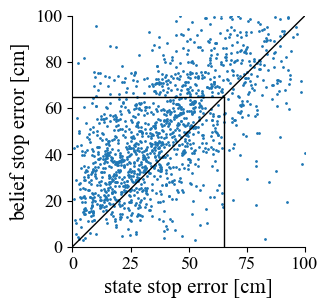

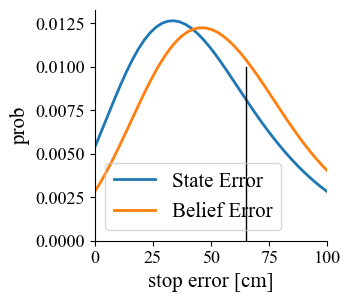

In [29]:
# state vs belief stop error
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.scatter(state_error,belief_error, s=1, alpha=1)
    ax.plot([0,222],[0,222],color='black', linewidth=1)
    ax.plot([0,65],[65,65],color='black', linewidth=1)
    ax.plot([65,65],[65,0],color='black', linewidth=1)
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    ax.set_xlabel('state stop error [cm]')
    ax.set_ylabel('belief stop error [cm]')
    # ax.axis('equal')
    quickspine(ax)
    fig.show()

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    sns.kdeplot(state_error, ax=ax, label='State Error',bw=0.5)
    sns.kdeplot(belief_error, ax=ax, label='Belief Error',bw=0.5)
    ax.plot([65,65],[0.01,0],color='black', linewidth=1)
    ax.set_xlabel('stop error [cm]')
    ax.set_ylabel('prob')
    ax.set_xlim(0,100)
    ax.legend()
    quickspine(ax)
    fig.show()

  

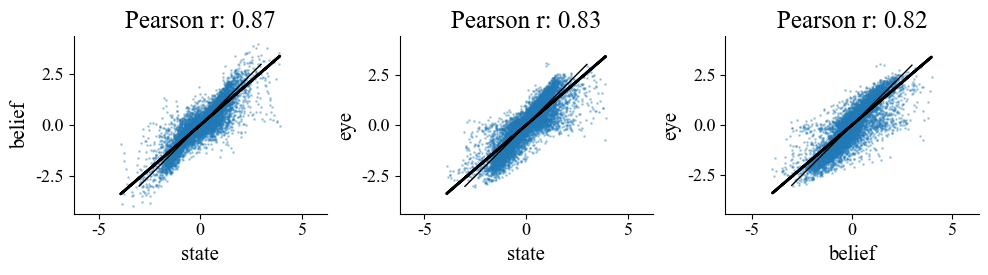

In [30]:
# state, eye, belief corr (masked by time ratio)

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    maskvar=np.concatenate(sessdf.time_ratio.to_numpy())
    mask=(maskvar<=0.6) & (maskvar>0.2)
    [state, belief, eye]=[a[mask] for a in [state, belief, eye]]
    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            
            plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])

            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            axs[k].set_title(f'Pearson r: {r:.2f}')
            k+=1
    plt.tight_layout()

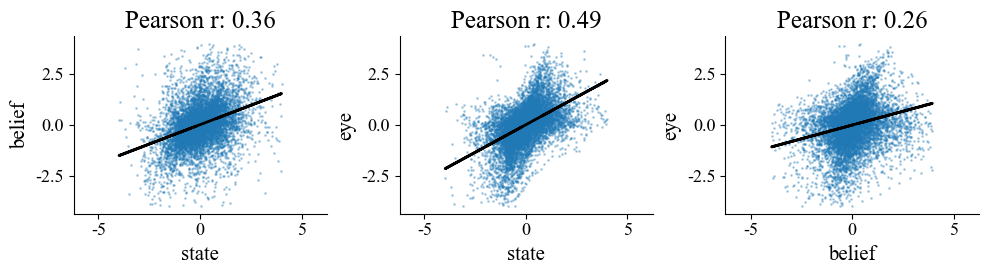

In [31]:
# state, eye, belief corr (masked by time)

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    markvar=np.concatenate(sessdf.timer.to_numpy())
    mask=(markvar>7)
    [state, belief, eye]=[a[mask] for a in [state, belief, eye]]

    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            # axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            
            plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])

            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            axs[k].set_title(f'Pearson r: {r:.2f}')
            k+=1
    plt.tight_layout()

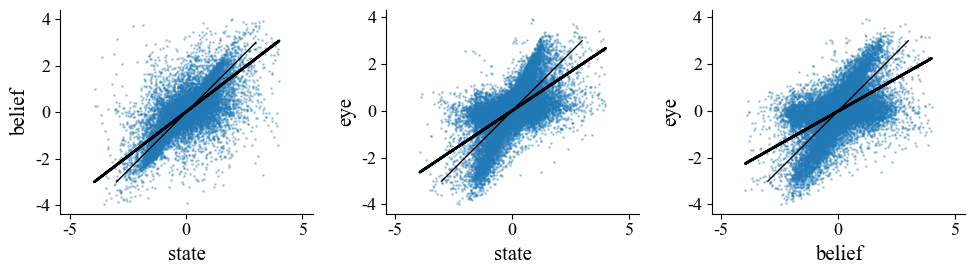

In [32]:
# state, eye, belief corr
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())

    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            s=plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            k+=1
    plt.tight_layout()

In [34]:
# # overhead stops subtraction
# state_error=(df.state_error.to_numpy())
# belief_error=(df.belief_error.to_numpy())

# fig, ax = plt.subplots(1,1, figsize=(4,4))
# overheadbase(ax)
# bsdiff=[a-b for a,b in zip(belief_error, state_error)]
# target_location=np.array([(x[0],y[0]) for x,y in zip(df.fx.to_list(), df.fy.to_list())])

# vm=np.max(np.abs(bsdiff))
# cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=bsdiff, cmap='bwr', vmin=-vm, vmax=vm)
# cbar = fig.colorbar(cax,shrink=0.6, label='belief reward - state reward')


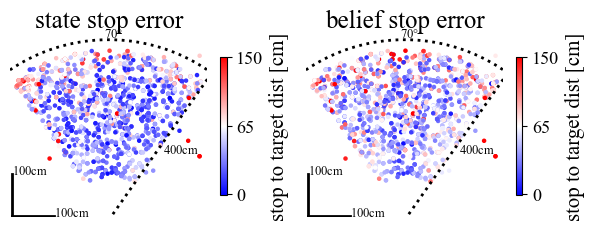

In [33]:
# overhead stops
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    target_location=np.array([(x[0],y[0]) for x,y in zip(sessdf.fx.to_list(), sessdf.fy.to_list())])
    norm=getcbarnorm(0, 65, 150)

    fig, axs = plt.subplots(1,2, figsize=(7,3))
    ax=axs[0]
    overheadbase(ax)
    cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=state_error, cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,150])
    cbar.ax.yaxis.set_ticklabels([0,65,150])
    ax.set_title('state stop error')

    ax=axs[1]
    overheadbase(ax)
    cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=belief_error, cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,150])
    cbar.ax.yaxis.set_ticklabels([0,65,150])
    ax.set_title('belief stop error')

    plt.show()

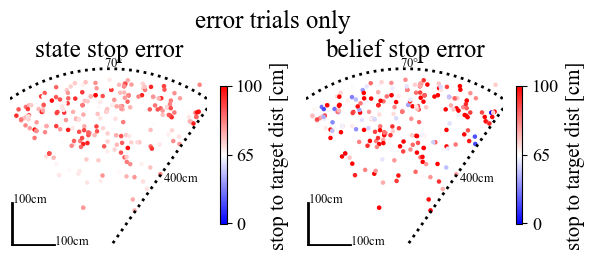

In [34]:
# overhead stops for error trials
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    target_location=np.array([(x[0],y[0]) for x,y in zip(sessdf.fx.to_list(), sessdf.fy.to_list())])
    norm=getcbarnorm(0, 65, 100)

    fig, axs = plt.subplots(1,2, figsize=(7,3))
    ax=axs[0]
    overheadbase(ax)
    mask=(state_error>65) & (state_error<100)
    cax=ax.scatter(target_location[mask,0], target_location[mask,1], s=5, c=state_error[mask], cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,100])
    cbar.ax.yaxis.set_ticklabels([0,65,100])
    ax.set_title('state stop error')

    ax=axs[1]
    overheadbase(ax)
    # mask= (belief_error>65) & (belief_error<100)
    cax=ax.scatter(target_location[mask,0], target_location[mask,1], s=5, c=belief_error[mask], cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,100])
    cbar.ax.yaxis.set_ticklabels([0,65,100])
    ax.set_title('belief stop error')
    fig.suptitle('error trials only')
    plt.show()

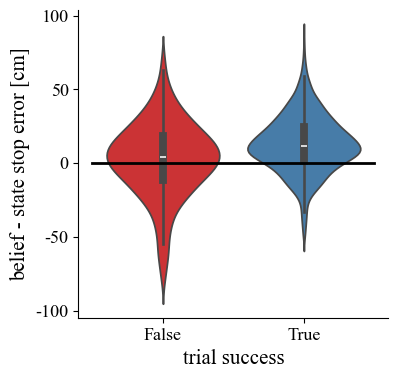


    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    


In [35]:
# radial err vs belief explaining corr
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    x,y=belief_error-state_error, state_error
    plt.figure(figsize=(4, 4))
    data = {
        "trial success": y<65,
        "belief explaining power": x,
    }
    sns.violinplot(x="trial success", y="belief explaining power", data=data, palette="Set1")
    plt.xlabel("trial success")
    plt.ylabel("belief - state stop error [cm]")
    plt.plot([-0.5,1.5],[0,0], color='k')
    plt.show()
    
print('''
    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    ''')

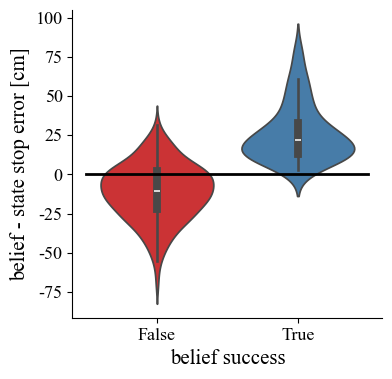


    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    for the trials mk think he hits, belief error > state error
    for the trials mk think he missed, belief error < state error.
    


In [36]:
# radial err vs belief explaining corr, error trails
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    mask=(state_error>65) & (state_error<100)
    x,y=state_error[mask]-belief_error[mask], belief_error[mask]
    plt.figure(figsize=(4, 4))
    data = {
        "trial success": y<65,
        "belief explaining power": x,
    }
    sns.violinplot(x="trial success", y="belief explaining power", data=data, palette="Set1")
    plt.xlabel("belief success")
    plt.ylabel("belief - state stop error [cm]")
    plt.plot([-0.5,1.5],[0,0], color='k')
    plt.show()
print('''
    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    for the trials mk think he hits, belief error > state error
    for the trials mk think he missed, belief error < state error.
    ''')

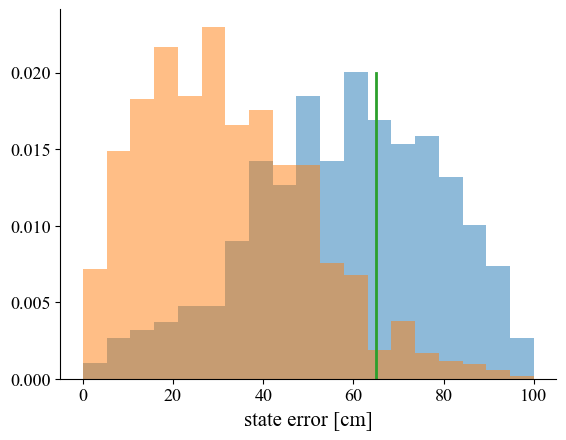

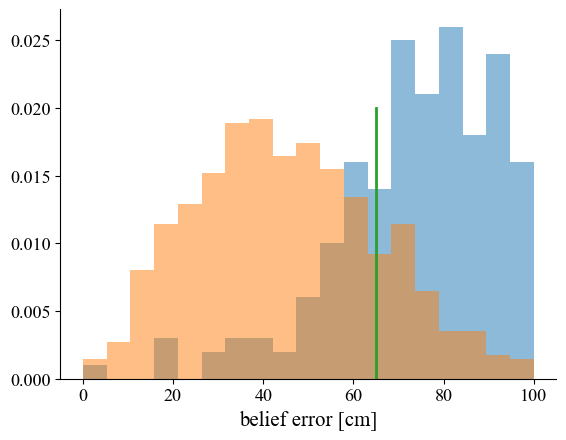

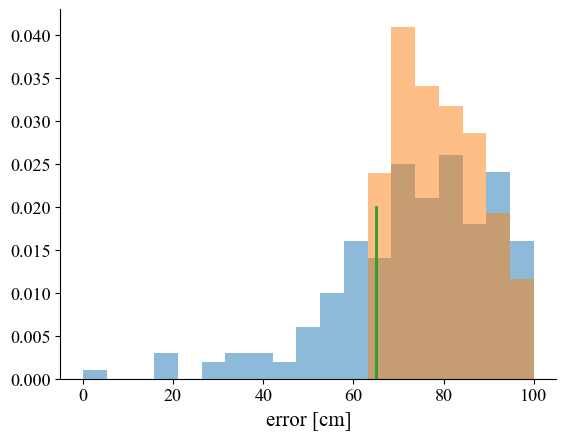

In [37]:
state_error=(df.state_error.to_numpy())
belief_error=(df.belief_error.to_numpy())

statefail=(state_error>65) & (state_error<100)
statehit=(state_error<=65) 
belieffail=(belief_error>65) & (belief_error<100)
beliefhit=(belief_error<=65) 

# plt.hist(state_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
# plt.hist(state_error[statehit], bins=np.linspace(0,100,20), alpha=0.5, density=True) 

plt.hist(state_error[belieffail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.hist(state_error[beliefhit], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.plot([65,65],[0,0.02])
plt.xlabel('state error [cm]')
plt.show()

plt.hist(belief_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.hist(belief_error[statehit], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.xlabel('belief error [cm]')
plt.plot([65,65],[0,0.02])
plt.show()

plt.hist(belief_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.hist(state_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.xlabel('error [cm]')
plt.plot([65,65],[0,0.02])

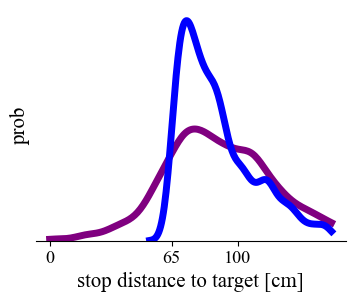

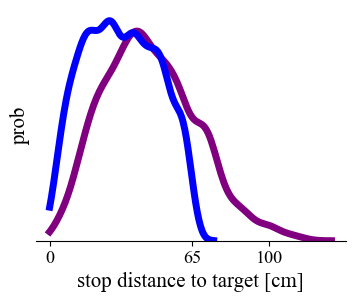

In [38]:
# histogram of distribution
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())

    statefail=(state_error>65) & (state_error<150)
    statehit=(state_error<=65) 
    belieffail=(belief_error>65) & (belief_error<150)
    beliefhit=(belief_error<=65) 

    fig, ax = plt.subplots(figsize=(4,3))
    # ax.hist(belief_error[statefail], bins=np.linspace(0,150,30), alpha=0.5, density=True) 
    # ax.hist(state_error[statefail], bins=np.linspace(0,150,30), alpha=0.5, density=True) 
    sns.kdeplot(belief_error[statefail],bw=0.2, clip=(0,150), linewidth=5, color=belief_color)
    sns.kdeplot(state_error[statefail],bw=0.2, clip=(0,150), linewidth=5, color=state_color)
    plt.xlabel('stop distance to target [cm]')
    plt.xticks([0,65,100])
    ax.yaxis.set_ticks([])
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('prob')
    # plt.xlim(0,100)
    plt.show()

    fig, ax = plt.subplots(figsize=(4,3))
    sns.kdeplot(belief_error[statehit],bw=0.2, clip=(0,150), linewidth=5, color=belief_color)
    sns.kdeplot(state_error[statehit],bw=0.2, clip=(0,150), linewidth=5, color=state_color)
    plt.xlabel('stop distance to target [cm]')
    plt.xticks([0,65,100])
    ax.yaxis.set_ticks([])
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('prob')
    # plt.xlim(0,100)
    plt.show()



In [39]:
# table (todo, roc)
state_error=(df.state_error.to_numpy())
belief_error=(df.belief_error.to_numpy())

statefail=(state_error>65) & (state_error<100)
statehit=(state_error<=65) 
belieffail=(belief_error>65) & (belief_error<100)
beliefhit=(belief_error<=65) 
statefail,statehit, belieffail, beliefhit=np.sum(statefail),np.sum(statehit),np.sum(belieffail),np.sum(beliefhit)

print('fail, hit\n state',statefail,statehit,'\n belief', belieffail, beliefhit)

fail, hit
 state 246 1192 
 belief 375 1017


In [42]:
# trialidx=np.random.choice(sessdf.trial.unique())
# eye_hori = sessdf[sessdf.trial == trialidx].eye_hori.to_list()[0]
# eye_vert = sessdf[sessdf.trial == trialidx].eye_vert.to_list()[0]
# ff_hori = sessdf[sessdf.trial == trialidx].ff_hori.to_list()[0]
# ff_vert = sessdf[sessdf.trial == trialidx].ff_vert.to_list()[0]
# belief_ff_hori = sessdf[sessdf.trial == trialidx].belief_ff_hori.to_list()[0]
# belief_ff_vert = sessdf[sessdf.trial == trialidx].belief_ff_vert.to_list()[0]

# # Create the plot
# fig, ax = plt.subplots()
# # Plot the gradient lines with custom colormaps
# plot_gradient_line(ax, eye_hori, eye_vert, cmap_eye)
# plot_gradient_line(ax, ff_hori, ff_vert, cmap_state)
# plot_gradient_line(ax, belief_ff_hori, belief_ff_vert, cmap_belief)
# plt.title(f'trial: {trialidx}')
# # quickallspine(ax)
# plt.show()

956


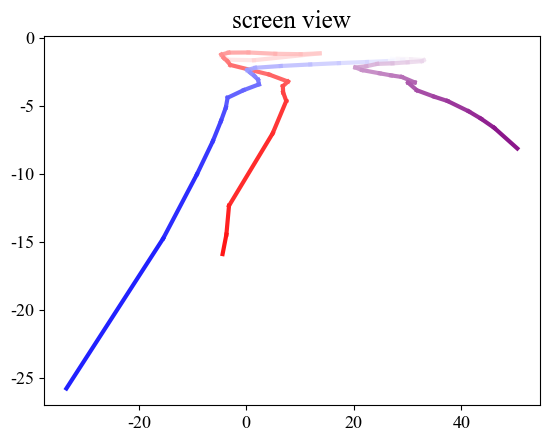

886


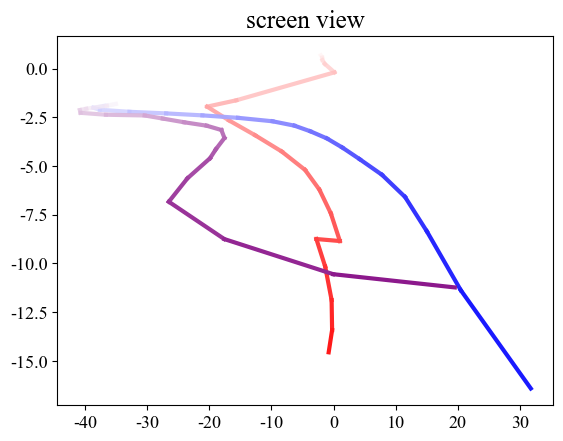

687


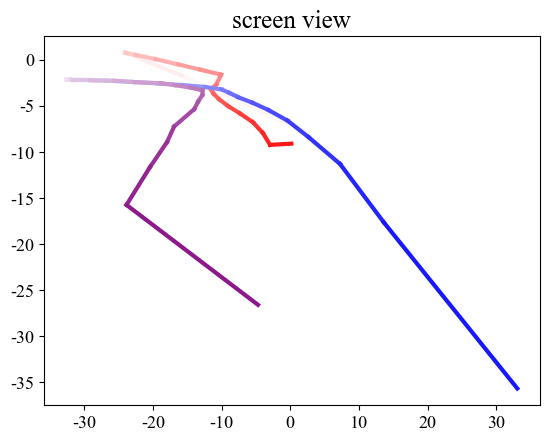

409


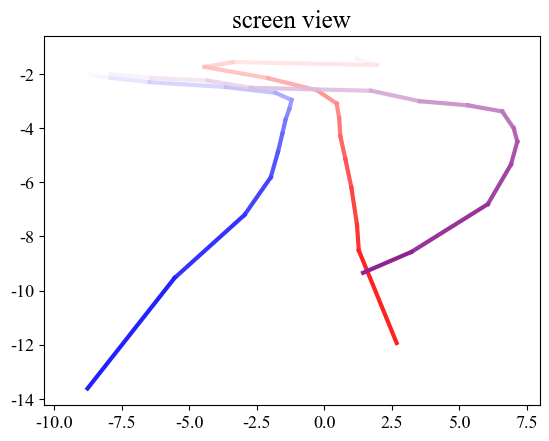

266


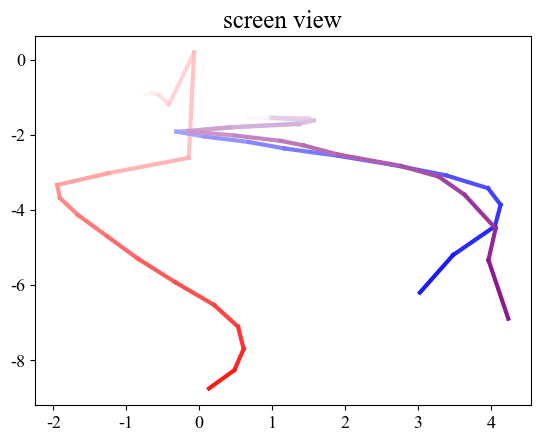

In [40]:
# screen view example trial

cmap_eye = mcolors.LinearSegmentedColormap.from_list('eye_cmap', ['white', eye_color])
cmap_state = mcolors.LinearSegmentedColormap.from_list('state_cmap', ['white', state_color])
cmap_belief = mcolors.LinearSegmentedColormap.from_list('belief_cmap', ['white', belief_color])

# trialidx=np.random.choice(sessdf.trial.unique())
for trialidx in [956,886,687,409,266]:
    print(trialidx)
    eye_hori = sessdf[sessdf.trial == trialidx].eye_hori.to_list()[0]
    eye_vert = sessdf[sessdf.trial == trialidx].eye_vert.to_list()[0]
    ff_hori = sessdf[sessdf.trial == trialidx].ff_hori.to_list()[0]
    ff_vert = sessdf[sessdf.trial == trialidx].ff_vert.to_list()[0]
    belief_ff_hori = sessdf[sessdf.trial == trialidx].belief_ff_hori.to_list()[0]
    belief_ff_vert = sessdf[sessdf.trial == trialidx].belief_ff_vert.to_list()[0]

    # Create the plot
    fig, ax = plt.subplots()
    # Plot the gradient lines with custom colormaps
    plot_gradient_line(ax, eye_hori, eye_vert, cmap_eye)
    plot_gradient_line(ax, ff_hori, ff_vert, cmap_state)
    plot_gradient_line(ax, belief_ff_hori, belief_ff_vert, cmap_belief)
    # plt.title(f'trial: {trialidx}')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    # ax.xaxis.set_ticks([])
    # ax.yaxis.set_ticks([])
    ax.set_title('screen view')
    plt.show()


956


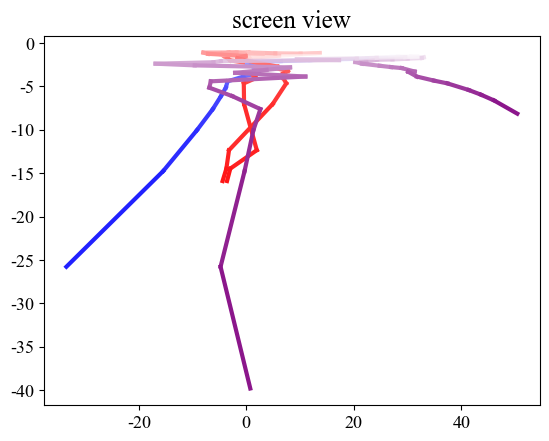

886


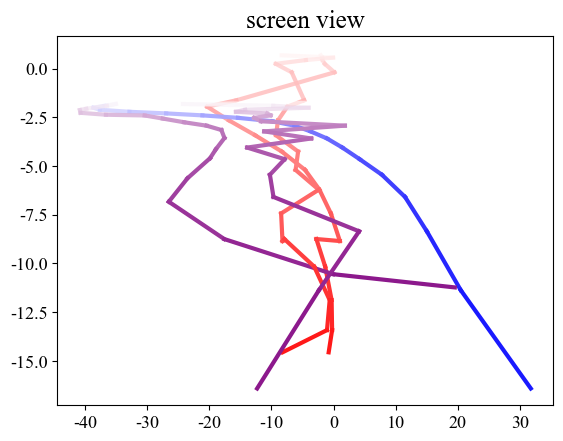

687


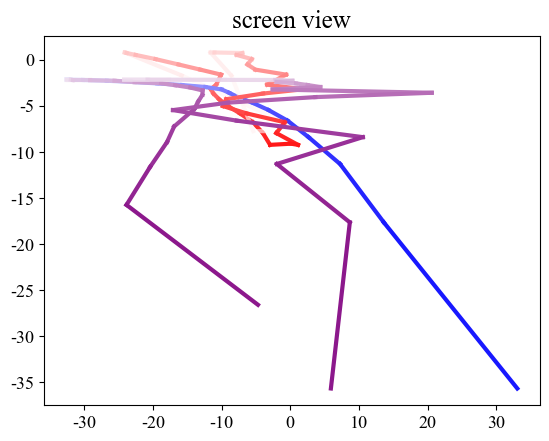

409


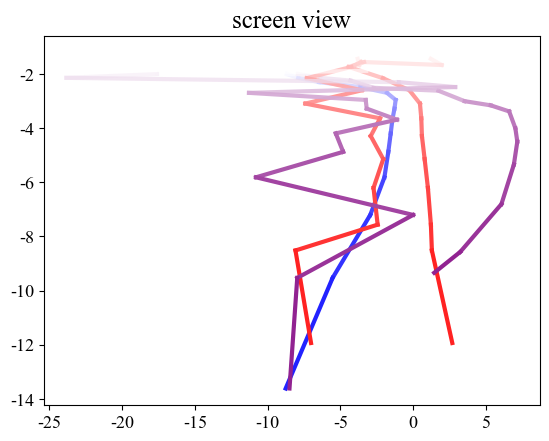

266


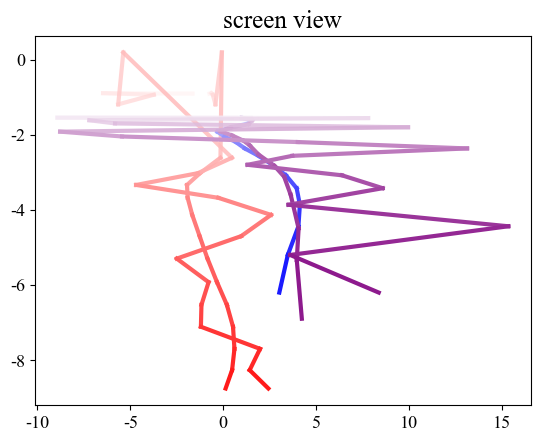

In [41]:
# screen view example trial (with neural belief and neural eye trajectory)

cmap_eye = mcolors.LinearSegmentedColormap.from_list('eye_cmap', ['white', eye_color])
cmap_state = mcolors.LinearSegmentedColormap.from_list('state_cmap', ['white', state_color])
cmap_belief = mcolors.LinearSegmentedColormap.from_list('belief_cmap', ['white', belief_color])

cmap_neuralbelief = mcolors.LinearSegmentedColormap.from_list('belief_cmap', ['white', belief_color])
cmap_neuraleye = mcolors.LinearSegmentedColormap.from_list('belief_cmap', ['white', eye_color])


thisr=np.vstack(timedf.PPC.to_list())
thise=timedf.eye.to_numpy().reshape(-1,1)
thisb=timedf.belief.to_numpy().reshape(-1,1)
neural2eye= LinearRegression()
neural2eye.fit(thisr, thise)
neural2belief= LinearRegression()
neural2belief.fit(thisr, thisb)



# trialidx=np.random.choice(sessdf.trial.unique())
for trialidx in [956,886,687,409,266]:
    print(trialidx)
    eye_hori = sessdf[sessdf.trial == trialidx].eye_hori.to_list()[0]
    eye_vert = sessdf[sessdf.trial == trialidx].eye_vert.to_list()[0]
    ff_hori = sessdf[sessdf.trial == trialidx].ff_hori.to_list()[0]
    ff_vert = sessdf[sessdf.trial == trialidx].ff_vert.to_list()[0]
    belief_ff_hori = sessdf[sessdf.trial == trialidx].belief_ff_hori.to_list()[0]
    belief_ff_vert = sessdf[sessdf.trial == trialidx].belief_ff_vert.to_list()[0]

    thisr=sessdf[sessdf.trial == trialidx].PPC.to_numpy()[0]

    neuralbelief=neural2belief.predict(thisr).reshape(-1)
    neuraleye=neural2eye.predict(thisr).reshape(-1)
    

    # Create the plot
    fig, ax = plt.subplots()
    # Plot the gradient lines with custom colormaps
    plot_gradient_line(ax, eye_hori, eye_vert, cmap_eye)
    plot_gradient_line(ax, ff_hori, ff_vert, cmap_state)
    plot_gradient_line(ax, belief_ff_hori, belief_ff_vert, cmap_belief)
    plot_gradient_line(ax, neuraleye, eye_vert, cmap_neuraleye)
    plot_gradient_line(ax, neuralbelief, ff_vert, cmap_neuralbelief)
    # plt.title(f'trial: {trialidx}')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    # ax.xaxis.set_ticks([])
    # ax.yaxis.set_ticks([])
    ax.set_title('screen view')
    plt.show()


Text(0.5, 0.98, 'not full on')

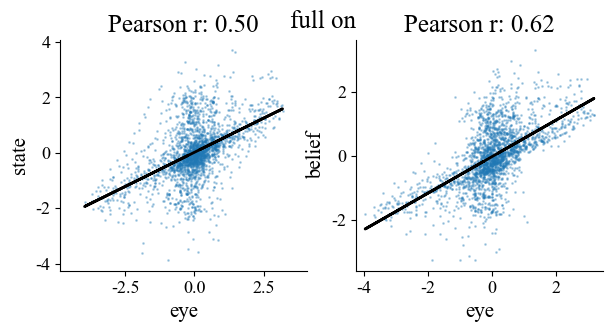

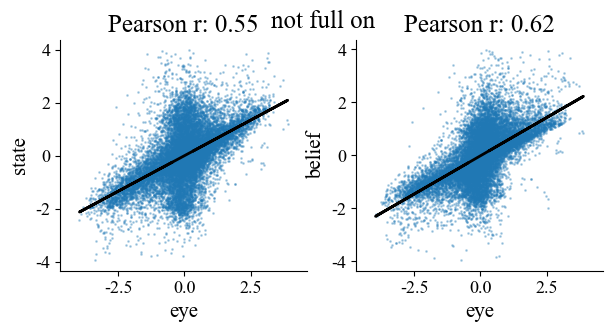

In [42]:
# correlation scatter
sessdf=df[df.fullon==1]

# state=np.concatenate(sessdf.heading.to_numpy())
# belief=np.concatenate(sessdf.belief_heading.to_numpy())
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())

mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
related_taskvar = process([state, belief, eye])
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    axs[i].scatter(related_taskvar[:,2], related_taskvar[:,i], s=1, alpha=0.3)
    # axs[i].plot([-3,3],[-3,3],color='black', linewidth=1)

    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])

    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on')

sessdf=df[df.fullon==0]
# state=np.concatenate(sessdf.heading.to_numpy())
# belief=np.concatenate(sessdf.belief_heading.to_numpy())
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())

mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
related_taskvar = process([state, belief, eye])
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    axs[i].scatter(related_taskvar[:,2], related_taskvar[:,i], s=1, alpha=0.3)
    # axs[i].plot([-3,3],[-3,3],color='black', linewidth=1)

    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])

    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('not full on')

Text(0.5, 0.98, 'not full on')

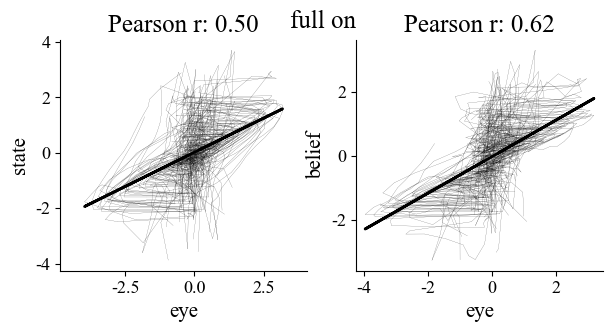

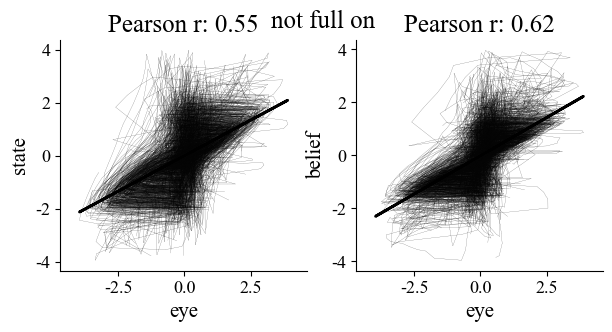

In [43]:
sessdf=df[df.fullon==1]
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timer=np.concatenate(sessdf.time_ratio.to_numpy())
mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
timer=timer[mask]
related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):

    for j in range(len(related_taskvar)-1):
        if timer[j]!=1:
            axs[i].plot([related_taskvar[j,2],related_taskvar[j+1,2]], [related_taskvar[j,i],related_taskvar[j+1,i]], linewidth=0.1, color='black')

    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on')

sessdf=df[df.fullon==0]
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timer=np.concatenate(sessdf.time_ratio.to_numpy())
mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
timer=timer[mask]
related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):

    for j in range(len(related_taskvar)-1):
        if timer[j]!=1:
            axs[i].plot([related_taskvar[j,2],related_taskvar[j+1,2]], [related_taskvar[j,i],related_taskvar[j+1,i]], linewidth=0.1, color='black')

    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('not full on')

Text(0.5, 0.98, 'full on, all data')

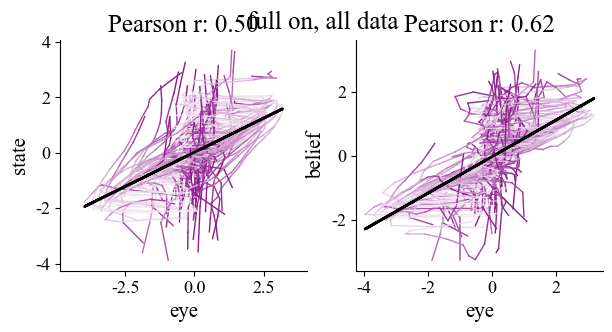

In [44]:
sessdf=df[(df.fullon==1)]
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timer=np.concatenate(sessdf.time_ratio.to_numpy())
mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
timer=timer[mask]
related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    s=0
    while s<len(related_taskvar):
        e=s+1
        while e<len(related_taskvar) and timer[e]!=0:
            e+=1
        # print(s,e)
        plot_gradient_line(axs[i], related_taskvar[s:e,2], related_taskvar[s:e,i], cmap=cmap_belief, linewidth=1)
        s=e
    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on, all data')

Text(0.5, 0.98, 'full on')

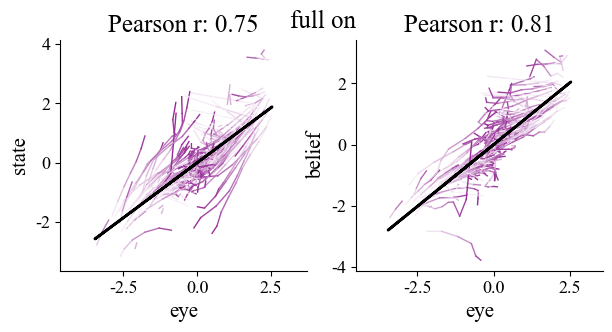

In [45]:
thisdf=timedf[(timedf.fullon==1)&((timedf.timeratio<0.7)&(timedf.timeratio>0.2))]
state=thisdf.state.to_numpy()
belief=thisdf.belief.to_numpy()
eye=thisdf.eye.to_numpy()
timer=thisdf.timeratio.to_numpy()

related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    s=0
    while s<len(related_taskvar):
        e=s+1
        while e<len(related_taskvar) and timer[e]>timer[e-1]:
            e+=1
        e-1
        # print(s,e, timer[s], timer[e])
        plot_gradient_line(axs[i], related_taskvar[s:e,2], related_taskvar[s:e,i], cmap=cmap_belief, linewidth=1)
        s=e
    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('full on')

Text(0.5, 0.98, 'not full on')

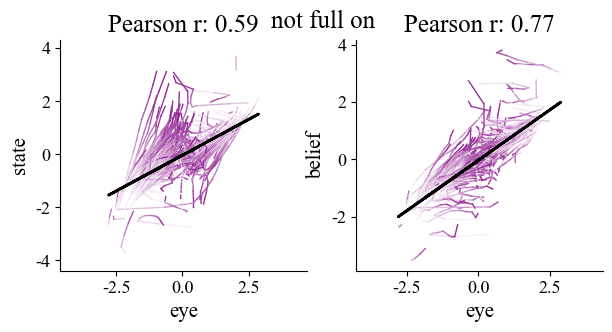

In [46]:
thisdf=timedf[(timedf.fullon==0)&((timedf.timeratio<0.7)&(timedf.timeratio>0.2))&(timedf.error>65)]
state=thisdf.state.to_numpy()
belief=thisdf.belief.to_numpy()
eye=thisdf.eye.to_numpy()
timer=thisdf.timeratio.to_numpy()

related_taskvar, mask = process([state, belief, eye], returnmask=True)
timer=timer[mask]
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    s=0
    while s<len(related_taskvar):
        e=s+1
        while e<len(related_taskvar) and timer[e]>timer[e-1]:
            e+=1
        e-1
        # print(s,e, timer[s], timer[e])
        plot_gradient_line(axs[i], related_taskvar[s:e,2], related_taskvar[s:e,i], cmap=cmap_belief, linewidth=1)
        s=e
    
    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])
    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,2])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1
plt.suptitle('not full on')